# **Practical session n°2**

Main notions:
- Convolutional layer and Pooling
- Two classical CNNs: VGG and ResNet
- ImageNet
- Self-organisation of kernels during training
- Feature maps

Duration: 1 h 30

In this part, we focus on convolutional layers, which are the basic building blocks of classical architectures such as VGG and ResNet50.
To understand their effect, we manipulate them a bit and introduce the maxpooling operations often associated with them (**A**). Then, we observe how their parameters have converged after training on the ImageNet database (**B**). We also visualize the output signal of the convolutional layers (**C**).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn   # pre-defined layers
from torch.utils.data import Dataset, DataLoader

# to load pre-trained models on ImageNet:
import torchvision
from torchvision import datasets, models, transforms

**A.** Convolutional Layers and Maxpooling

Before defining the convolutional layers, let's examine two standard deep learning models (vgg16 and resnet50). In the final layers, you will recognize perceptrons ("classifier"), formed from the nn.Linear class. \
But, in the first part of the network, you see the 'conv2d' layers that correspond to these convolutional layers.

In [2]:
# Two deep neural networks: VGG16 and ResNet50
model = models.vgg16(pretrained=False)
# model = models.resnet50(pretrained=False)
print(model)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In the simplest case, in one dimension, the "convolution" is defined by a relation of the form:
\begin{equation*}
output_i = bias + \sum_{j = 1}^n input_{i + j} \times kernel_{j}  \tag{1}
\end{equation*}
Here, $kernel$ represents a vector of size $n$ containing the parameters of the neuron. If, for example, $kernel$ is positive and has a sum of 1, it is a moving average. Finally, note that the classic convolution operator differs slightly ($input_{i - j}$ instead of $input_{i + j}$).

The PyTorch code is more complicated because:
- the input is generally a batch of images with multiple channels
- there is not only one neuron in the layer

The general form is defined [here](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d).

On this page, $N$, $C_{out}$, and, $C_{in}$ correspond respectively to the batch size, the number of neurons in the layer, and the number of input channels.

The operator $\star$ also hides subtleties: you need to set how the kernel moves on the input (*stride*) and deal with border issues (*padding*). These aspects, which we will not dwell on, are easier to understand from the animations by [Vincent Dumoulin](https://github.com/vdumoulin/conv_arithmetic).

To illustrate the effect of a 2D convolutional layer with one neuron, let's load an RGB image.

In [3]:
# Clone the repo
! git clone https://github.com/nanopiero/ML_S5_etudiants.git

Cloning into 'ML_S5_etudiants'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 82 (delta 26), reused 6 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (82/82), 1.33 MiB | 10.65 MiB/s, done.
Resolving deltas: 100% (26/26), done.


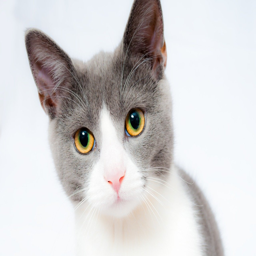

In [4]:
# Load the jpg image of a cat with the library PIL
from PIL import Image
root = 'ML_S5_etudiants/practicals/P2'
path = os.path.join(root, 'cat.jpg')
image = Image.open(path).convert("RGB")
image = image.resize((256,256))
image

The "convolution" operators used by the `Conv2d` class are coded in the `torch.nn.functional` module. In the following lines, we define a Gaussian kernel that can then be applied to the image:

/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


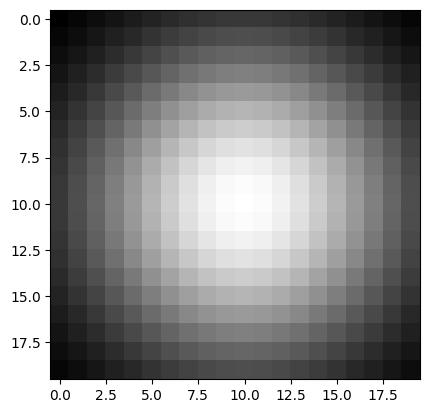

In [5]:
# Definition of a Gaussian kernel of size 10
x_range = torch.arange(-5, 5, 0.5)
y_range = torch.arange(-5, 5, 0.5)
xx, yy = torch.meshgrid(x_range, y_range)
var = 10

kernel =  (1./(2.*3.14*var)) * torch.exp( - (xx**2 + yy**2)/(2*var) )  # Gaussian

plt.imshow(kernel, cmap='gray')

In [6]:
# Applying the same kernel to all channels:
kernel = kernel.repeat(1,3,1,1)                        # repeat for each R,G,B channel

# We added at the beginning the dimension associated with the image indexing in the batch ("batch dimension"):
print(kernel.shape)

torch.Size([1, 3, 20, 20])


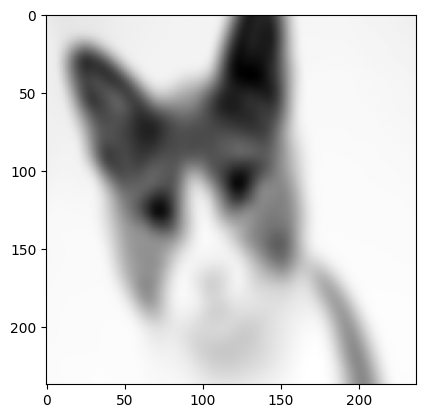

In [7]:
# Converting the 'cat.jpg' image to torch.tensor:
img = transforms.ToTensor()(image)
img = img.unsqueeze(dim=0)  # add the "batch dimension"

# Convolution:
import torch.nn.functional as F
output = F.conv2d(img, kernel)
fig = plt.figure()
plt.imshow(output[0,0,:,:], cmap='gray')

In practice, kernels of such large size are rarely used. For example, in a VGG, the kernels are of size 3*3. This is sufficient to extract interesting features, such as contours.

**Exercise 1:** Apply a [Prewitt filter](https://en.wikipedia.org/wiki/Prewitt_operator) to the image using PyTorch's `conv2d` (complete the following code).

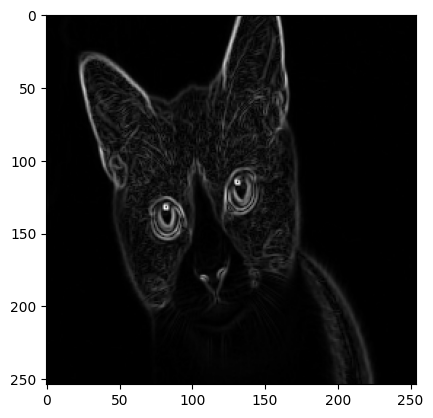

In [11]:
kernel1 = torch.tensor([[1, 1, 1],[0, 0, 0],[-1, -1, -1]], dtype=torch.float32)
kernel2 = torch.tensor([[-1, 0, 1],[-1, 0, 1],[-1, 0, 1]], dtype=torch.float32)


kernel1 = kernel1.repeat(1,3,1,1)
kernel2 = kernel2.repeat(1,3,1,1)

# YOUR CODE HERE
output1 = F.conv2d(img, kernel1)
output2 = F.conv2d(img, kernel2)

output = (output1**2 + output2**2).sqrt()

fig = plt.figure()
plt.imshow(output[0,0,:,:], cmap='gray')

However, the Prewitt filter cannot be encoded in a standard neural network: it involves a square root. The nonlinearities implemented in these networks are simpler:

- the **ReLU function**. It is simply the "positive part" function.
- **maxpooling**. It is a form of downsampling. In its most common form, the image is divided into 2*2 pixel squares, and the maximum value in each square is returned. The spatial dimensions of the output tensor are thus divided by two.  

In [12]:
# Positive part: ReLU function
x = torch.rand(1,1,4,4) - 0.5
print(x)
print(x.relu())

# Maxpooling:
x = F.max_pool2d(x, kernel_size=2)
print(x)

tensor([[[[-0.0870, -0.1124,  0.2010,  0.0649],
          [ 0.4248,  0.2183,  0.4660, -0.2687],
          [ 0.0650, -0.2573,  0.2511, -0.0741],
          [-0.3730,  0.1114,  0.2906, -0.2548]]]])
tensor([[[[0.0000, 0.0000, 0.2010, 0.0649],
          [0.4248, 0.2183, 0.4660, 0.0000],
          [0.0650, 0.0000, 0.2511, 0.0000],
          [0.0000, 0.1114, 0.2906, 0.0000]]]])
tensor([[[[0.4248, 0.4660],
          [0.1114, 0.2906]]]])


**Exercise 2:** What is the size of the tensor at the output of layer 30 of vgg16, compared to that of the input image?


**B.** Convolution Kernels After Training

Let's now observe the convolutional layers after training on a very large set of annotated images (~1M) from the ImageNet database ([http://www.image-net.org/challenges/LSVRC/2010/index](https://)). First, let's see what happens to the kernels associated with the 64 neurons in the first convolutional layer of a pre-trained ResNet50:

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([64, 3, 7, 7])


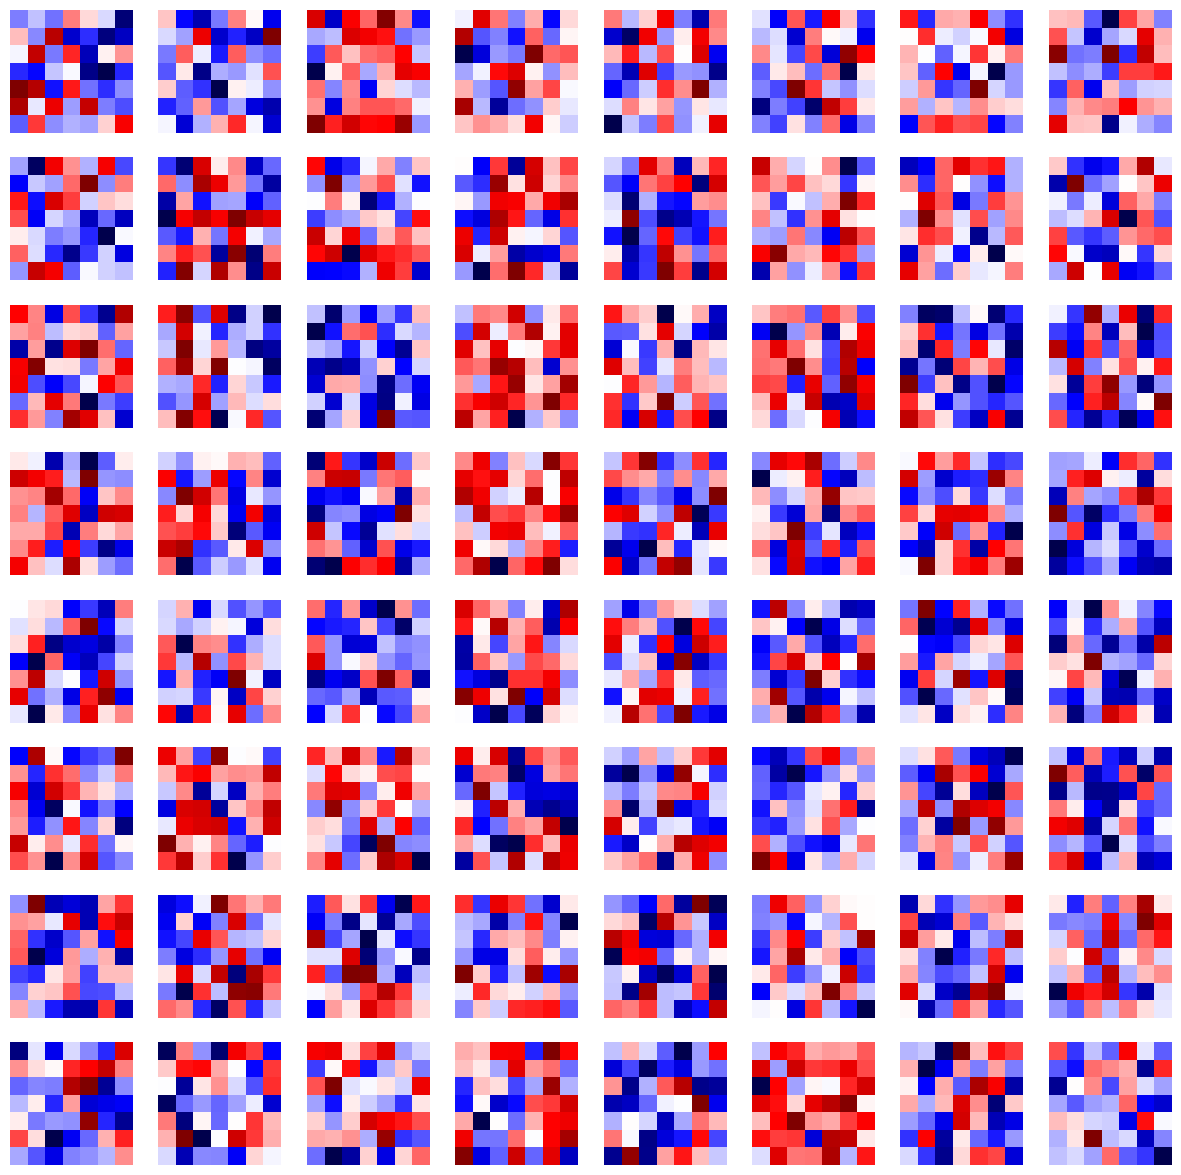

In [13]:
# Before training:
model = models.resnet50(pretrained=False)
first_layer = model.conv1.weight.data

print(first_layer.shape)

plt.figure(figsize=(15, 15))
for i in range(first_layer.shape[0]):
    plt.subplot(8, 8, i+1) #
    plt.imshow(first_layer[i, 0, :, :], cmap='seismic')
    plt.axis('off')
plt.show()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 298MB/s]


torch.Size([64, 3, 7, 7])


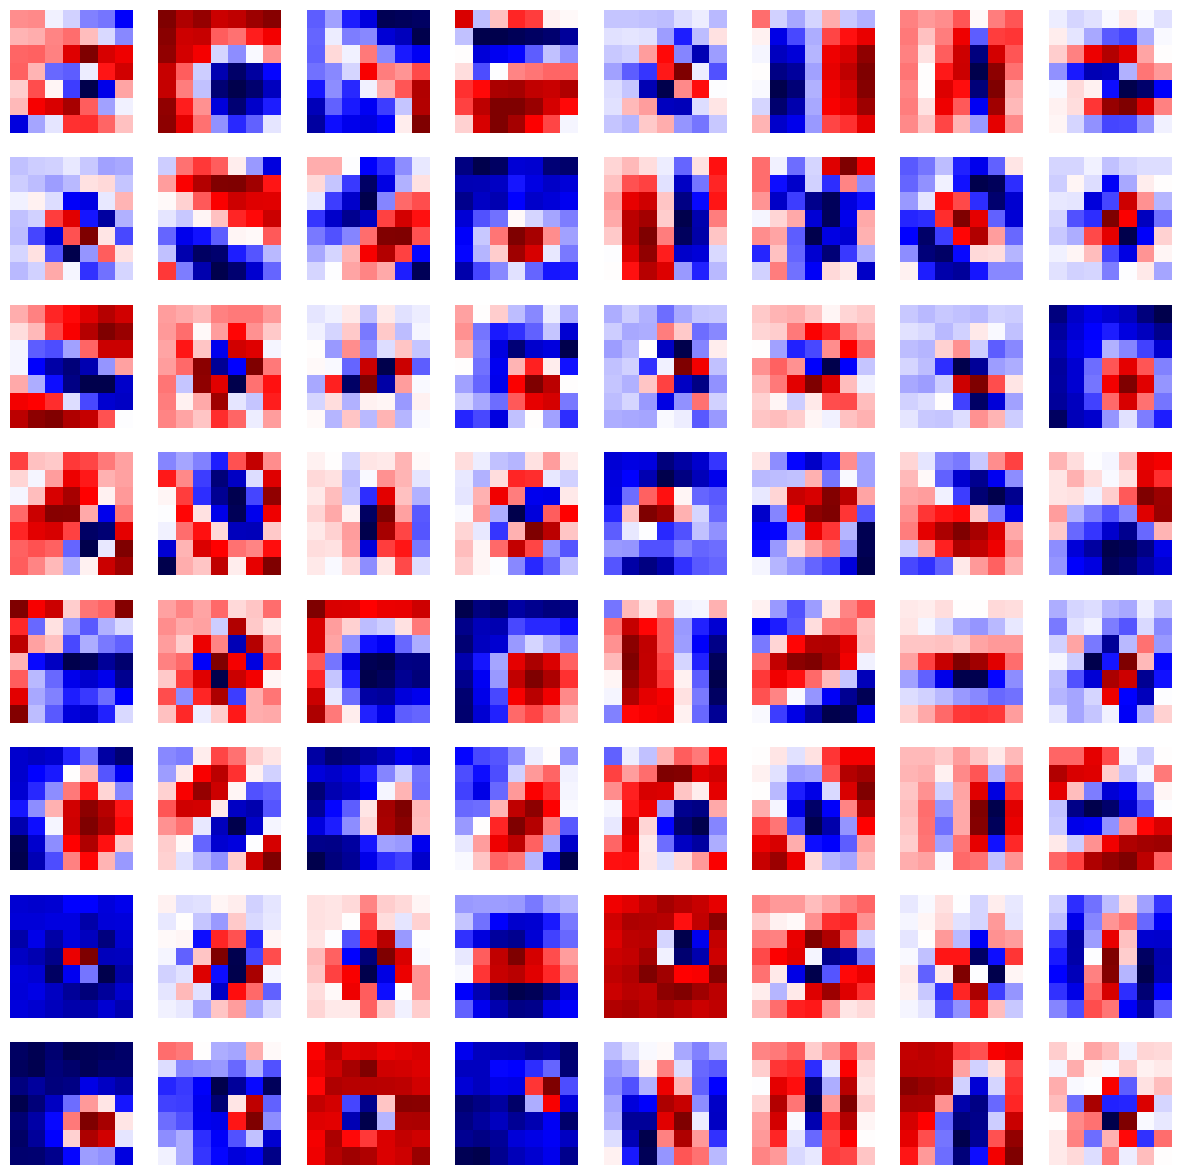

In [14]:
# After training:
model = models.resnet50(pretrained=True)
first_layer = model.conv1.weight.data

print(first_layer.shape)

plt.figure(figsize=(15, 15))
for i in range(first_layer.shape[0]):
    plt.subplot(8, 8, i+1) #
    plt.imshow(first_layer[i, 0, :, :], cmap='seismic')
    plt.axis('off')
plt.show()

Among these kernels, we find contour extractors similar to the Prewitt filter.  
Signal processing enthusiasts will even recognize patterns very close to the [Morlet wavelets](https://www.google.com/search?q=wavelet+morlet+2d&rlz=1C1AVFC_enFR826FR857&hl=fr&sxsrf=ALeKk01sWHdzUO6bRogEv0KFx2gRgOWz_Q:1610077971021&source=lnms&tbm=isch&sa=X&ved=2ahUKEwiIq5fst4vuAhXPxYUKHaskDqAQ_AUoAXoECAUQAw&biw=915&bih=591).  
This is remarkable: through a simple gradient descent, effective filters for shape recognition have **emerged**.

**Exercise 3:** How many "neurons" does the first convolutional layer of a ResNet50 have (one kernel per neuron)?  
How many weights are there in a kernel?  
How many weights does this layer contain?

In [15]:
# This can be verified with the module.parameters() generator,
# applicable to any instance of torch.nn
nb_weights = 0
for parameter in model.conv1.parameters():
  # numel: counts the number of elements in a tensor
  nb_weights += torch.numel(parameter)

print(nb_weights)

9408


**C.** Feature Maps

Now let's see what happens to the image as it passes through the network. Let's take VGG16, pass it on our cat image, and see how the signal changes as it propagates through the network. First, let's see if the network recognizes the correct class among the thousand classes in the dataset. The list of classes is [here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

In [16]:
image = Image.open(path).convert("RGB")
image = image.resize((256,256))

img = transforms.ToTensor()(image)

img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)
img = img.unsqueeze(dim=0)

In [17]:
model = models.vgg16(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 80.8MB/s]


tensor([285])


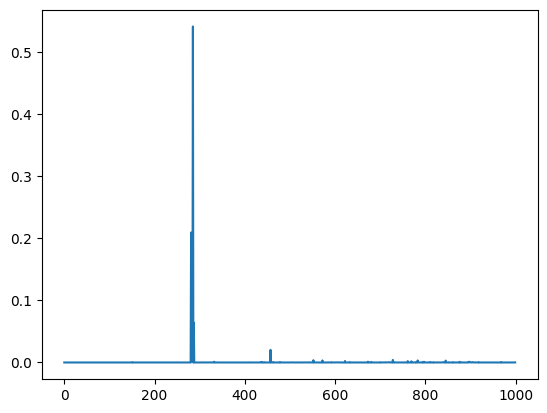

In [22]:
# Raw output
output = model(img)

# Softmax function
output = output.softmax(dim=1).detach()

# Prediction
_, c  = torch.max(output, dim=1)
print(c)

# "Probabilities" associated with classes
plt.plot(output.squeeze())

You may notice that by running the last cell several times, the output probabilities differ even though the input does not change. This is due to "dropout" (check `print(model)`), which deactivates a random subset of the classifier neurons (this operation helps combat **overfitting**).  

To disable "dropout" and freeze the network, switch to "eval" mode with the command:  

*model.eval()*

Now, let's visualize the signal at the output of a convolutional layer. For this, we can use the [*hook*](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html) command. The channels of these intermediate signals are called **feature maps**. Let's see the feature maps associated with the first convolutional layer:

In [23]:
z = []
# Function that stores in the list z the "feature maps"
def store_layer_output(model, input, output):
        z.append(output.detach())


model.features[0].register_forward_hook(store_layer_output)
model.features[10].register_forward_hook(store_layer_output)
model.features[17].register_forward_hook(store_layer_output)
model.features[28].register_forward_hook(store_layer_output)

output = model(img)

In [24]:
for fm in z:
  print(fm.shape)

torch.Size([1, 64, 256, 256])
torch.Size([1, 256, 64, 64])
torch.Size([1, 512, 32, 32])
torch.Size([1, 512, 16, 16])


**Exercise 4:** Visualize the feature maps of layers 0, 10, 17, 28. You will notice that at level 10, the neuron's response is often specific to a particular trait.

torch.Size([1, 256, 64, 64])


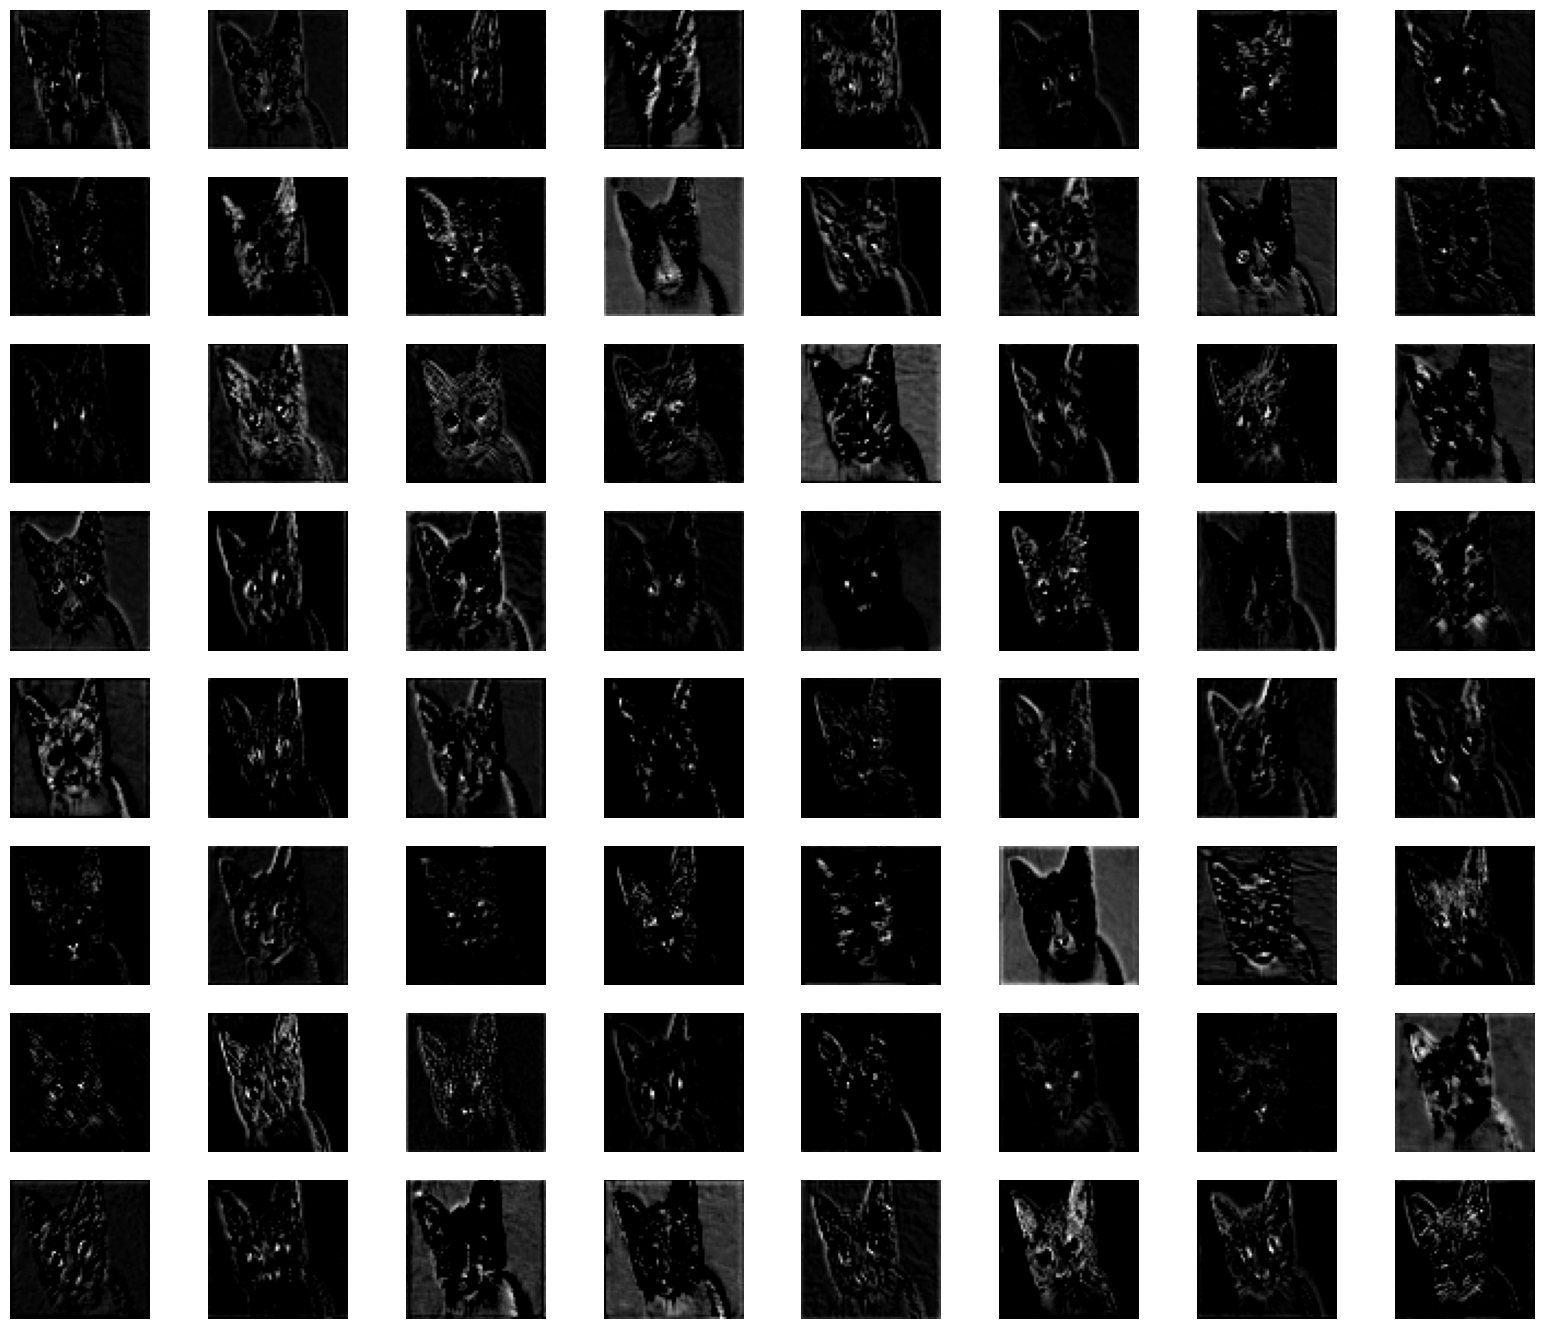

In [25]:
feature_maps = z[1]

print(feature_maps.shape)
plt.figure(figsize=(20, 17))
# for i in range(...):
#    plt.subplot(...)
#    plt.imshow(...)
#    plt.axis('off') # don't show plot axis
# YOUR CODE HERE
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(feature_maps[0, i, :, :].squeeze(), cmap='gray')
    plt.axis('off') # don't show plot axis

plt.show()

Overlay on the original image:

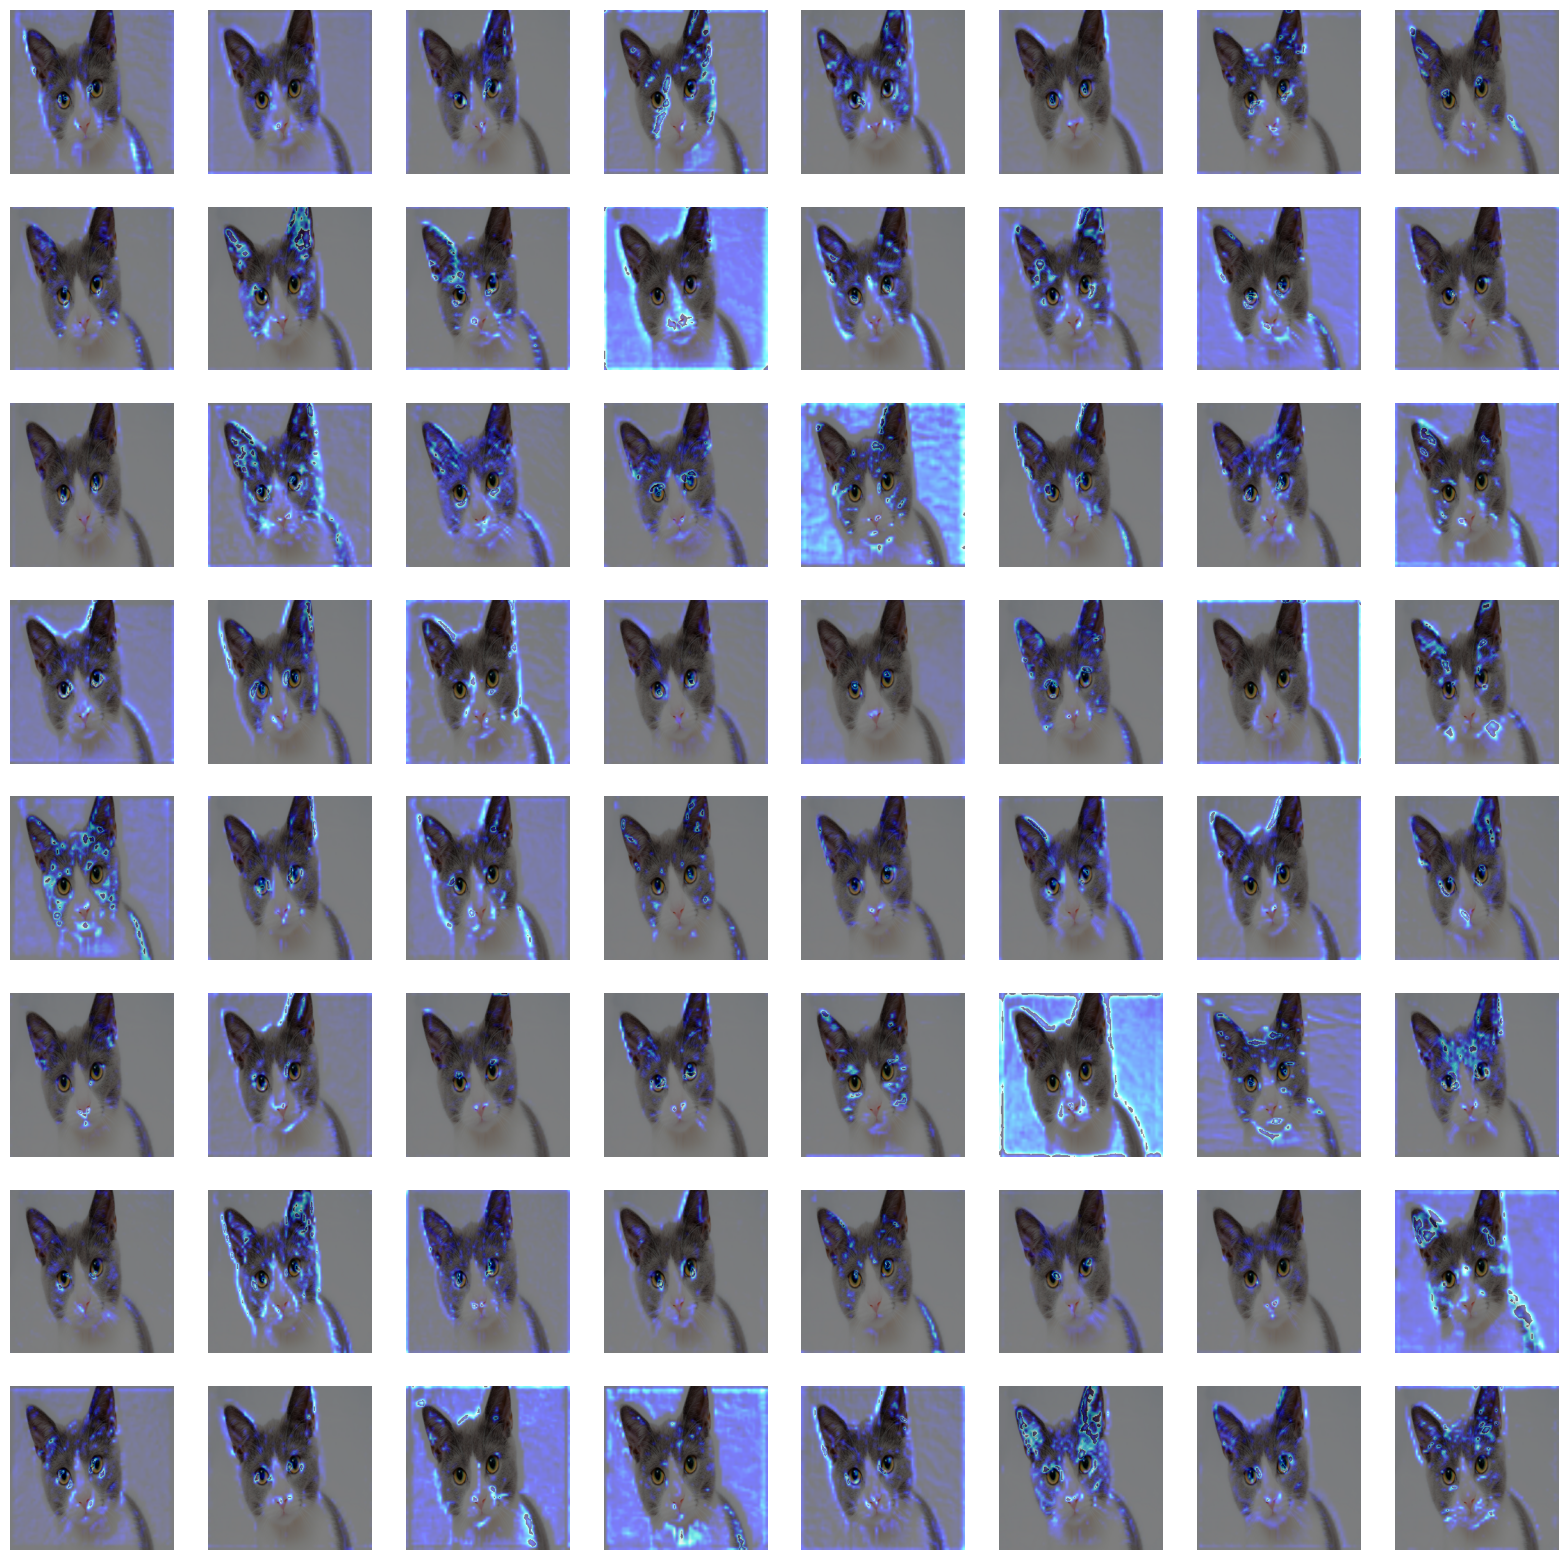

In [31]:
import cv2
# load image
# YOUR CODE HERE
image = Image.open(path).convert("RGB") # Load the original image again
image = image.resize((256,256)) # Resize to match the feature map dimensions approximately


f, axes = plt.subplots(8,8)
for i in range(64):
    ax = axes[i//8][i%8]
    # fm1 = feature map
    # YOUR CODE HERE
    fm1 = feature_maps[0, i, :, :].squeeze().numpy() # Get the feature map and convert to numpy
    fm1 = cv2.resize(fm1, (image.size))
    fm1 /= 0.5*np.max(fm1)
    fm1 = np.uint8(fm1*255)
    fm1 = cv2.applyColorMap(fm1,  cv2.COLORMAP_HOT)
    fm1 = Image.fromarray(fm1)

    superp = Image.blend(image, fm1, 0.5)
    ax.axis('off')
    ax.imshow(superp)
f.set_figheight(20)
f.set_figwidth(20)
plt.show() # Add plt.show() to display the figure